# Portfolio Generator
This is a portfolio generator for personal portfolio management

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from typing import Union
from sklearn import linear_model, covariance

In [12]:
class Market:
  """Market Class (Abstract)
  
  Params:
   - start: start date to retrieve historical data
   - end: end date to retrieve historical data
  """
  def __init__(self, start: str, end: Union[str, None] = None) -> None:
    self.start = start
    self.end = end
  
  def retrieve_data(self):
    raise NotImplementedError("Data retrieval not implemented")
    
  def calc_stats(self):
    self.calc_risk_free_rate()
    self.calc_volatility()
    
  def calc_risk_free_rate(self):
    raise NotImplementedError("Rf rate not implemented")
    
  def calc_volatility(self):
    raise NotImplementedError("Market volatility not implemented")

  def __str__(self) -> str:
    return f'Market Reference: {self.ticker}\n  Risk-free rate: {self.risk_free_rate}\n  True Volatility: {self.volatility}'

In [13]:
class MarketIndex(Market):
  """Index-based Market Class
  
  Params:
   - ticker: index to track
   - start: start date to retrieve historical data
   - end: end date to retrieve historical data
  """
  def __init__(self, ticker: str,  start: str, end: Union[str, None] = None) -> None:
    self.ticker = ticker
    Market.__init__(self, start, end)
    self.retrieve_data()
    self.calc_stats()
    
  def retrieve_data(self):
    self.data = yf.download(self.ticker, start = self.start, end = self.end, auto_adjust=True)
    self.data = self.data[['Close']].copy()
    self.data.dropna(inplace=True)
    self.data['Return'] = self.data['Close'].pct_change()
    
  def calc_risk_free_rate(self):
    self.risk_free_rate = np.mean(self.data['Return'])
    
  def calc_volatility(self):
    self.volatility = np.std(self.data['Return'])

In [57]:
class MarketFF(Market):
  """Fama-French Data-based Market Class
  
  Params:
   - file: csv file from Ken French's Fama-French database
   - start: start date to retrieve historical data
   - end: end date to retrieve historical data
  """
  def __init__(self, start: str, end: Union[str, None] = None) -> None:
    self.ticker = 'Fama-French'
    Market.__init__(self, start, end)
    self.retrieve_data()
    self.calc_stats()
    
  def retrieve_data(self):
    self.data = pd.read_csv('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip', compression='zip', skiprows=[0,1,2]).dropna()
    self.data.columns = ['DATE', 'MKTRF', 'SMB', 'HML', 'RF']
    self.data['RF'] = self.data['RF'] / 100
    self.data['DATE'] = pd.to_datetime(self.data['DATE'], format='%Y%m%d')
    if self.end is None:
      self.data = self.data[(self.data['DATE'] >= self.start)]
    else:
      self.data = self.data[(self.data['DATE'] >= self.start) & (self.data['DATE'] <= self.end)]
      
  def calc_risk_free_rate(self):
    self.risk_free_rate = np.mean(self.data['RF'])
    
  def calc_volatility(self):
    self.volatility = 0

In [428]:
class Portfolio:
  """Portfolio Class
  
  Params:
   - tickers: the list of stocks to generate the portfolio
   - start: start date to retrieve historical data
   - end: end date to retrieve historical data
  """
  def __init__(self, tickers: list = [], start: str = "2014-01-01", end: Union[str, None] = None) -> None:
    if len(tickers) <= 1:
      raise Exception("Tickers must be a list of at least 2 assets")
    self.tickers = [ticker.upper() for ticker in tickers]
    self.tickers.sort()
    self.start = start
    self.end = end
    self.retrieve_data()
    self.calc_stats()
    
  def __str__(self) -> str:
    return f'Portfolio Assets: {self.tickers}\n  Average Return: {self.mean_returns}\n  Expected Return: {self.expected_returns}'
    
  def retrieve_data(self):
    self.data = yf.download(self.tickers, start = self.start, end = self.end, auto_adjust=True)
    self.data = self.data[['Close']]
    
    returns = self.data[['Close']].pct_change()
    returns.columns = returns.columns.set_levels(['Return'], level=0)
    self.data = pd.concat([self.data, returns], axis=1)
  
  def calc_stats(self):
    self.calc_mean_returns()
    self.calc_expected_returns()
    self.calc_covariance_matrix()
  
  def calc_mean_returns(self):
    self.mean_returns = [np.mean(self.data['Return'][ticker]) for ticker in self.tickers]
    
  def calc_expected_returns(self):
    """Uses the Fama-French 3 Factor Model"""
    returns = self.data['Return'].reset_index().melt(id_vars=["Date"], var_name="ASSET", value_name="RET").dropna()
    returns.columns = ['DATE', 'ASSET', 'RET']
    
    ff3 = pd.read_csv('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip', compression='zip', skiprows=[0,1,2]).dropna()
    ff3.columns = ['DATE', 'MKTRF', 'SMB', 'HML', 'RF']
    ff3['RF'] = ff3['RF'] / 100
    ff3['DATE'] = pd.to_datetime(ff3['DATE'], format='%Y%m%d')
    
    merged = pd.merge(returns, ff3, on="DATE")
    merged["XRET"] = merged["RET"] - merged["RF"]
    grouped = merged.groupby(["ASSET"])

    beta = {'ASSET':[], 'ff3_alpha':[], 'ff3_beta':[], 'smb_beta':[], 'hml_beta':[]}
    ret = {'ASSET': [], 'DATE': [], 'FF3_RET': []}

    for name, group in grouped:
        ff3model = linear_model.LinearRegression().fit(group[["MKTRF", "SMB", "HML"]], group["XRET"])
        
        beta['ASSET'].append(name)
        beta['ff3_alpha'].append(ff3model.intercept_)
        beta['ff3_beta'].append(ff3model.coef_[0])
        beta['smb_beta'].append(ff3model.coef_[1])
        beta['hml_beta'].append(ff3model.coef_[2])
        
        ret['ASSET'].extend([name] * len(group))
        ret['DATE'].extend(group["DATE"])
        ret['FF3_RET'].extend(ff3model.predict(group[["MKTRF", "SMB", "HML"]]) + group["RF"])
        
    self.beta = pd.DataFrame(beta)
    self.beta['ERET'] = self.beta['ff3_alpha'] + self.beta['ff3_beta'] * np.mean(merged['MKTRF']) + self.beta['smb_beta'] * np.mean(merged['SMB']) + self.beta['hml_beta'] * np.mean(merged['HML'])
    self.expected_returns = self.beta['ERET'].to_list()
    
  def calc_covariance_matrix(self):
    """Calculates the covariance matrix using OAS shrinkage"""
    weekly_returns = self.data['Return'].resample('1W').mean().applymap(lambda x: (x + 1)**7 - 1).fillna(0)
    # monthly_returns = self.data['Return'].resample('1M').mean().applymap(lambda x: (x + 1)**30 - 1)
    self.cov_matrix = covariance.oas(weekly_returns)[0]

In [334]:
class MVO:
  """Mean Variance Optimization Class
  
  Params:
   - portfolio: the portfolio to optimize
   - market: the market reference
   - bounds: constraint on the weight of each stock where 1 == 100% and negative means shorting
  """
  def __init__(self, portfolio: Portfolio, market: Market, bounds: Union[list, None] = None) -> None:
    self.portfolio = portfolio
    self.market = market
    self.bounds = bounds
  
  def pf_variance(self, weights):
    return np.dot(weights.T, np.dot(self.portfolio.cov_matrix, weights))
  
  def pf_volatility(self, weights):
    return np.sqrt(self.pf_variance(weights))
  
  def pf_return(self, weights):
    return np.dot(weights.T, self.portfolio.expected_returns)
  
  def pf_return_negate(self, weights):
    return -np.dot(weights.T, self.portfolio.expected_returns)
  
  def pf_sharpe(self, weights, risk_free_rate):
    return -(self.pf_return(weights) - risk_free_rate) / self.pf_volatility(weights)
    
  def pf_utility(self, weights, risk_aversion):
    return -(self.pf_return(weights) - (1 / 2) * risk_aversion * self.pf_volatility(weights))
  
  def minimum_variance(self, expected_return=None):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)

    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    if not (expected_return is None):
      constraints.append({"type": "eq", "fun": lambda x: self.pf_return(x) - expected_return})

    result = minimize(fun=self.pf_variance,
                      x0=init_guess,
                      args=(),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)

    self.stats = {
      "Weights": result.x,
      "Returns": np.sum(self.portfolio.expected_returns * result.x),
      "Volatility": np.sqrt(result.fun)
    }
    
  def maximum_return(self, expected_volatility):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)

    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
                   {"type": "eq", "fun": lambda x: self.pf_volatility(x) - expected_volatility}]

    result = minimize(fun=self.pf_return_negate,
                      x0=init_guess,
                      args=(),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)

    self.stats = {
      "Weights": result.x,
      "Returns": -result.fun,
      "Volatility": self.pf_volatility(result.x)
    }
  
  def maximum_sharpe(self):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)

    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]

    result = minimize(fun=self.pf_sharpe,
                      x0=init_guess,
                      args=(self.market.risk_free_rate),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)

    self.stats = {
      "Weights": result.x,
      "Returns": np.sum(self.portfolio.expected_returns * result.x),
      "Volatility": self.pf_volatility(result.x),
      "Sharpe": -result.fun
    }
    
  def maximum_utility(self, risk_aversion=10):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)    

    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]

    result = minimize(fun=self.pf_utility,
                      x0=init_guess,
                      args=(risk_aversion),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)

    self.stats = {
      "Weights": result.x,
      "Returns": np.sum(self.portfolio.expected_returns * result.x),
      "Volatility": self.pf_volatility(result.x),
      "Utility": -result.fun
    }
    
  def plot_MVO(self):
    self.minimum_variance()
    returns = np.linspace(self.stats['Returns'] - 0.001, self.stats['Returns'] + 0.002, 51)
    vol = []
    for ret in returns:
      self.minimum_variance(ret)
      vol.append(self.stats["Volatility"])
    plt.plot(vol, returns)
    plt.title('Mean Variance Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.show()

[*********************100%***********************]  1 of 1 completed
Market Reference: ^GSPC
  Risk-free rate: 0.0004882915114136135
  True Volatility: 0.014496710116372588

Market Reference: Fama-French
  Risk-free rate: 0.0001238323353293416
  True Volatility: 0

[*********************100%***********************]  5 of 5 completed
Portfolio Assets: ['AAPL', 'GOOGL', 'MSFT', 'NFLX', 'TSLA']
  Average Return: [0.0011931514923494496, 0.0009382902057706153, 0.0010937006451560674, 0.0008849065778596556, 0.003091290908437963]
  Expected Return: [0.0011277032851781362, 0.0008728419985993014, 0.001028252437984754, 0.0008194583706883415, 0.0030258427012666445]


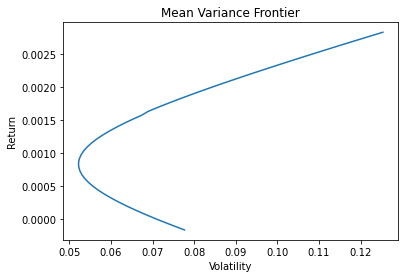

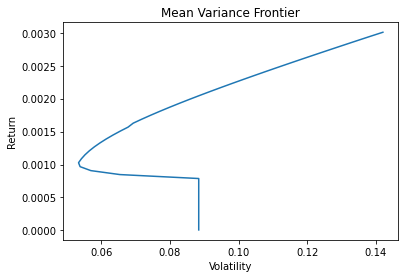

In [335]:
# Example Usage
index_market = MarketIndex('^GSPC', "2020-01-01", "2023-12-29")
print(index_market)
ff_market = MarketFF("2022-01-01", "2023-12-29")
print(ff_market)
portfolio = Portfolio(['aapl', 'googl', 'msft', 'nflx', 'tsla'], "2020-01-01", "2023-12-29")
print(portfolio)
mvo_idx = MVO(portfolio, index_market, None)
mvo_idx.plot_MVO()
mvo_ff = MVO(portfolio, ff_market, [[0,1]] * len(portfolio.tickers))
mvo_ff.plot_MVO()

In [336]:
mvo_idx.maximum_sharpe()
mvo_idx.stats

{'Weights': array([ 0.52080921, -0.36518987,  0.40290179, -0.49361755,  0.93509643]),
 'Returns': 0.00310780560993526,
 'Volatility': 0.14019617255532987,
 'Sharpe': 0.018684633473055965}

In [337]:
mvo_idx.minimum_variance()
mvo_idx.stats

{'Weights': array([ 0.34007937,  0.27992277,  0.39615912,  0.07023412, -0.08639539]),
 'Returns': 0.0008313236466197796,
 'Volatility': 0.052124480811407525}

In [338]:
mvo_ff.maximum_sharpe()
mvo_ff.stats

{'Weights': array([3.19057853e-01, 3.98986399e-17, 3.06211593e-01, 6.50521303e-18,
        3.74730554e-01]),
 'Returns': 0.0018085411177814995,
 'Volatility': 0.07712267763838027,
 'Sharpe': 0.021844531777690235}

In [339]:
mvo_ff.minimum_variance()
mvo_ff.stats

{'Weights': array([3.13634742e-01, 2.65454847e-01, 3.69966720e-01, 5.09436919e-02,
        4.60785923e-19]),
 'Returns': 0.0010075524838235727,
 'Volatility': 0.05320545603755546}

## Testing

In [340]:
def plotReturns(portfolio: Portfolio, reference: MarketIndex, weights: list):
  market_trace = [1000]
  for ret in reference.data['Return'][1:]:
    market_trace.append(market_trace[-1] * (1+ret))

  portfolio_trace = portfolio.data["Return"].copy()
  portfolio_trace.iloc[0] = weights
  portfolio_trace.iloc[0] *= 1000

  for idx in portfolio_trace.index[1:]:
    portfolio_trace.loc[idx] = portfolio_trace.shift(1).loc[idx] * (1+portfolio.data["Return"].loc[idx])
    
  portfolio_trace['total'] = portfolio_trace.sum(axis=1)
  
  plt.plot(reference.data.index, market_trace, label="Index")
  plt.plot(portfolio_trace.index, portfolio_trace['total'], label="Portfolio")
  plt.title(f'{reference.ticker} Index vs Optimized Portfolio from {portfolio.start} to {portfolio.end}')
  plt.legend(loc='best')
  plt.xlabel('Dates')
  plt.ylabel('Returns')
  plt.show()

In [463]:
nasdaq100 = open('nasdaq100.txt', 'r').read().split('\n')
dj30 = open('dj30.txt', 'r').read().split('\n')
train_data = nasdaq100
train_data.remove('GEHC')
train_data.remove('CEG')
train_data.remove('GFS')

In [464]:
train_start, train_end = ["2000-01-01", "2020-12-29"]
market_train = MarketFF(train_start, train_end)
print(market_train)
portfolio_train = Portfolio(train_data, train_start, train_end)
print(portfolio_train)

Market Reference: Fama-French
  Risk-free rate: 6.19973494888313e-05
  True Volatility: 0

[*********************100%***********************]  98 of 98 completed
Portfolio Assets: ['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'AVGO', 'AZN', 'BIIB', 'BKNG', 'BKR', 'CCEP', 'CDNS', 'CDW', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DLTR', 'DXCM', 'EA', 'EXC', 'FANG', 'FAST', 'FTNT', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KHC', 'KLAC', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDB', 'MDLZ', 'MELI', 'META', 'MNST', 'MRNA', 'MRVL', 'MSFT', 'MU', 'NFLX', 'NVDA', 'NXPI', 'ODFL', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'SPLK', 'TEAM', 'TMUS', 'TSLA', 'TTD', 'TTWO', 'TXN', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']
  Average Return: [0.001302185332245689, 0.00407074431631776, 0

In [465]:
test_start, test_end = ["2023-01-01", "2024-02-29"]
market_test = MarketIndex('^NDX', test_start, test_end)
print(market_test)
portfolio_test = Portfolio(train_data, test_start, test_end)
print(portfolio_test)

[*********************100%***********************]  1 of 1 completed
Market Reference: ^NDX
  Risk-free rate: 0.0018189935087631396
  True Volatility: 0.011302842429616385

[*********************100%***********************]  98 of 98 completed
Portfolio Assets: ['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'AVGO', 'AZN', 'BIIB', 'BKNG', 'BKR', 'CCEP', 'CDNS', 'CDW', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DLTR', 'DXCM', 'EA', 'EXC', 'FANG', 'FAST', 'FTNT', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KHC', 'KLAC', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDB', 'MDLZ', 'MELI', 'META', 'MNST', 'MRNA', 'MRVL', 'MSFT', 'MU', 'NFLX', 'NVDA', 'NXPI', 'ODFL', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'SPLK', 'TEAM', 'TMUS', 'TSLA', 'TTD', 'TTWO', 'TXN', 'VRSK', 'VRTX', 'WBA', 'WBD', 'W

In [466]:
mvo_train = MVO(portfolio_train, market_train, [[0,1]] * len(train_data))
mvo_train.maximum_sharpe()
mvo_train.stats

{'Weights': array([2.92706538e-02, 0.00000000e+00, 7.21096089e-17, 2.47857087e-16,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.89286453e-16,
        0.00000000e+00, 6.88917484e-03, 0.00000000e+00, 0.00000000e+00,
        7.63430795e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.55533152e-02, 1.37315825e-02, 0.00000000e+00, 0.00000000e+00,
        1.00527564e-16, 1.80165252e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.23045462e-02, 0.00000000e+00, 2.97842195e-16, 0.00000000e+00,
        0.00000000e+00, 2.49053097e-16, 0.00000000e+00, 2.36389955e-16,
        5.03561418e-03, 1.76653803e-16, 8.14151128e-17, 0.00000000e+00,
        1.60386281e-03, 4.42744122e-17, 0.00000000e+00, 0.00000000e+00,
        1.32958762e-16, 1.94621066e-16, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.19435469e-16, 0.00000000e+0

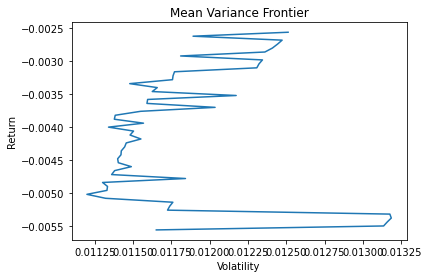

In [467]:
mvo_train.plot_MVO()

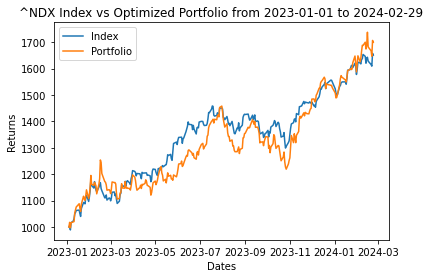

In [468]:
plotReturns(portfolio_test, market_test, mvo_train.stats['Weights'])